# Analysis of the Fast Food Marketing Campaign A/B Test dataset

### **Table of contents**<a id='toc0_'></a>    
- 1. [Introduction](#toc1_)    
- 2. [Data preparation](#toc2_)    
  - 2.1. [Downloading the dataset and reviewing meta data](#toc2_1_)    
  - 2.2. [Loading the data](#toc2_2_)    
- 3. [Data cleaning](#toc3_)    
  - 3.1. [Setting data types](#toc3_1_)    
  - 3.2. [Describing the data](#toc3_2_)    
  - 3.3. [Handling missing values](#toc3_3_)    
  - 3.4. [Deduplication process](#toc3_4_)    
  - 3.5. [Outliers: identification and handling](#toc3_5_)    
    - 3.5.1. [Rule-based method](#toc3_5_1_)    
    - 3.5.2. [Statistical outliers](#toc3_5_2_)    
- 4. [A/B testing](#toc4_)    
  - 4.1. [Mission/Goal definition](#toc4_1_)    
  - 4.2. [Metrics definition](#toc4_2_)    
  - 4.3. [Calculations](#toc4_3_)    
    - 4.3.1. [Cumulative Sales per Store](#toc4_3_1_)    
    - 4.3.2. [Additional thoughts on Market Size](#toc4_3_2_)    
    - 4.3.3. [Sanity Check](#toc4_3_3_)    
    - 4.3.4. [Average cumulative Sales per Promotion](#toc4_3_4_)    
    - 4.3.5. [Differences in average cumulative Sales](#toc4_3_5_)    
  - 4.4. [Results and Decisions](#toc4_4_)    
- 5. [Dashboard](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Introduction](#toc0_)

This project aims to assess the effectiveness of three distinct marketing promotions for a new menu item at a fast-food chain. By implementing an A/B testing approach across several randomly selected market locations, the study evaluates the impact of each promotion on weekly sales over a four-week period. The primary objective is to determine which promotional strategy yields the highest average cumulative sales. Through statistical analysis, including the calculation of median differences and bootstrapped confidence intervals, the findings will guide the fast-food chain in selecting the most effective marketing campaign, ultimately driving sales and enhancing customer engagement with the new product.

## 2. <a id='toc2_'></a>[Data preparation](#toc0_)

Import necessary libraries:

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp
import seaborn as sns

Hide warnings within jupyter notebook outputs:

In [2]:
{
    "tags": [
        "hide-input",
    ]
}
import warnings

warnings.simplefilter("ignore")

### 2.1. <a id='toc2_1_'></a>[Downloading the dataset and reviewing meta data](#toc0_)

Download the Fast Food Marketing Campaign A\B Test dataset [here](https://www.kaggle.com/datasets/chebotinaa/fast-food-marketing-campaign-ab-test).

**Meta data** for the dataset:

***Context***

**Scenario**

A fast-food chain plans to add a new item to its menu. However, they are still undecided between three possible marketing campaigns for promoting the new product. In order to determine which promotion has the greatest effect on sales, the new item is introduced at locations in several randomly selected markets. A different promotion is used at each location, and the weekly sales of the new item are recorded for the first four weeks.

**Goal**

Evaluate A/B testing results and decide which marketing strategy works the best.

***Content***

There are a total of 7 variables/columns and 548 entries in this dataset. The detailed description of features/columns:

**MarketID**: unique identifier for market

**MarketSize**: size of market area by sales

**LocationID**: unique identifier for store location

**AgeOfStore**: age of store in years

**Promotion**: one of three promotions that were tested

**week**: one of four weeks when the promotions were run

**SalesInThousands**: sales amount for a specific LocationID, Promotion, and week

### 2.2. <a id='toc2_2_'></a>[Loading the data](#toc0_)

In [3]:
df_orig = pd.read_csv("../data/WA_Marketing-Campaign.csv")
df = df_orig
df.shape

(548, 7)

The dataset consists of 548 rows/datapoints and 7 columns/features.
Below we can get a quick look on the first 5 records and the columns:

In [4]:
df.sort_index().head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


## 3. <a id='toc3_'></a>[Data cleaning](#toc0_)

Before analysing the data, the data cleansing process must deal with setting the data type, handling missing values, deduplicating samples and characteristics and identifying and processing outliers.

### 3.1. <a id='toc3_1_'></a>[Setting data types](#toc0_)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


The columns *MarketSize* and *Promotion* can be of data type `category` since they consist of a distinct list of categories (see below). 

The column *MarketSize* even follows an ordinal scale of size: *Small* < *Medium* < *Large*.


In [6]:
print(df["MarketSize"].value_counts())
print()
print(df["Promotion"].value_counts())

MarketSize
Medium    320
Large     168
Small      60
Name: count, dtype: int64

Promotion
3    188
2    188
1    172
Name: count, dtype: int64


Consequently columns *course_Certificate_type* and *course_difficulty* are set as data type `category`:

In [7]:
df["Promotion"] = df["Promotion"].astype("category")
df["MarketSize"] = pd.Categorical(
    df["MarketSize"], categories=["Small", "Medium", "Large"], ordered=True
)

In [8]:
df["MarketSize"].dtype

CategoricalDtype(categories=['Small', 'Medium', 'Large'], ordered=True, categories_dtype=object)

Column *SalesInThousands* should be typical a numerical variable indicating the true sales value, therefore we create a new column `Sales`:

In [9]:
df["Sales"] = df["SalesInThousands"] * 1_000

In [10]:
df["Sales"].describe()

count      548.000000
mean     53466.204380
std      16755.215822
min      17340.000000
25%      42545.000000
50%      50200.000000
75%      60477.500000
max      99650.000000
Name: Sales, dtype: float64

### 3.2. <a id='toc3_2_'></a>[Describing the data](#toc0_)

In [11]:
df["LocationID"].nunique()

137

There are 137 unique fast-food chain locations in the dataset. For each of the locations 4 datapoints representing the 4 weeks of the running promotion campaign:

In [12]:
df["week"].value_counts()

week
1    137
2    137
3    137
4    137
Name: count, dtype: int64

Thus we have 548 datapoints. The three different promotions are unequally distributed across the locations, which has to be taken into account for further analysis:

In [13]:
df.groupby("Promotion", observed=False)["LocationID"].nunique()

Promotion
1    43
2    47
3    47
Name: LocationID, dtype: int64

Promotion campaign "1" ran in 43 locations only, while campaign "2" and "3" ran in 47 locations each.

10 markets were randomly selected, in which the following number of locations are situated:

In [14]:
df.groupby("MarketID", observed=False)["LocationID"].nunique()

MarketID
1     13
2      6
3     22
4      9
5     15
6     15
7     15
8     12
9     10
10    20
Name: LocationID, dtype: int64

Each market (`MarketID`) has one particular `MarketSize`:

In [15]:
pd.crosstab(df["MarketID"], df["MarketSize"]) / 4

MarketSize,Small,Medium,Large
MarketID,,,
1,0.0,13.0,0.0
2,6.0,0.0,0.0
3,0.0,0.0,22.0
4,9.0,0.0,0.0
5,0.0,15.0,0.0
6,0.0,15.0,0.0
7,0.0,15.0,0.0
8,0.0,12.0,0.0
9,0.0,10.0,0.0


The promotions should be assigned to the locations randomly. We want to see how the distribution of `MarketSize` is for each promotion:

In [16]:
pd.crosstab(df["Promotion"], df["MarketSize"], margins=True, margins_name="Total") / 4

MarketSize,Small,Medium,Large,Total
Promotion,,,,
1,5.0,24.0,14.0,43.0
2,4.0,27.0,16.0,47.0
3,6.0,29.0,12.0,47.0
Total,15.0,80.0,42.0,137.0


In fact the promotions are rather similarly assinged to locations in particularly sized markets. However, promotion number 3 has less locations in the large market and promotion number 1 has less locations in total.

The fastfood chain stores (locations) are between 1 and 28 years old, on average around 8.5 years:

In [17]:
df["AgeOfStore"].describe()

count    548.000000
mean       8.503650
std        6.638345
min        1.000000
25%        4.000000
50%        7.000000
75%       12.000000
max       28.000000
Name: AgeOfStore, dtype: float64

### 3.3. <a id='toc3_3_'></a>[Handling missing values](#toc0_)

No missing values were detected (see 3.1), thus no handling is required.

### 3.4. <a id='toc3_4_'></a>[Deduplication process](#toc0_)

Looking at the distribution of variables/columns above already revealed that there are only unique records. We can confirm it once more as following:

In [18]:
df.duplicated().value_counts()

False    548
Name: count, dtype: int64

Thus, no further deduplication is required.

### 3.5. <a id='toc3_5_'></a>[Outliers: identification and handling](#toc0_)

Identifying outliers in the data follows a three step plan:
1) Using data visualization techniques to inspect the data’s distribution and verify the presence of outliers
2) Using a statistical method to calculate the outlier data points
3) Applying a statistical method to flag, drop or transform the outliers

Moreover, a two-level approach is applied to check both types of outliers, *natural* and *anomalous*: the rule-based method and the statistical approach. 

#### 3.5.1. <a id='toc3_5_1_'></a>[Rule-based method](#toc0_)

The decribed variables/columns did not reveal any unreasonable values.

#### 3.5.2. <a id='toc3_5_2_'></a>[Statistical outliers](#toc0_)

As next, the `Sales` feature is visualized (via boxplot and histogram) to detect possible outliers:

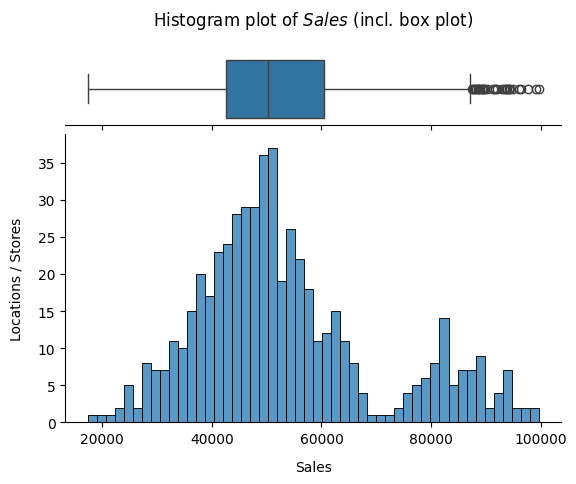

In [19]:
f, (ax_box, ax_hist) = plt.subplots(
    2, sharex=True, gridspec_kw={"height_ratios": (0.20, 0.80)}
)

sns.boxplot(x=df["Sales"], ax=ax_box)
sns.histplot(x=df["Sales"], bins=50, ax=ax_hist)

ax_box.set(yticks=[])
ax_hist.set_ylabel("Locations / Stores", labelpad=10)
ax_hist.set_xlabel("Sales", labelpad=10)
ax_box.set_title(r"Histogram plot of $\it{Sales}$ (incl. box plot)", pad=20)
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
plt.subplots_adjust(hspace=0.05)
plt.show()

We can see from the histogram above that there are two, rather normally distributed subsets of data, because there are clearly two peaks/modes in the histogram visible. This consquently leads to a detection of outliers at the right as seen in the boxplot. 

This can be the effect of the promotion, but I can also highlight differences in the market size. We want to go further into the A/B testing in the next chapter, so we will skip particular analysis of weeks here. But we can quickly show multiple histograms by market size:

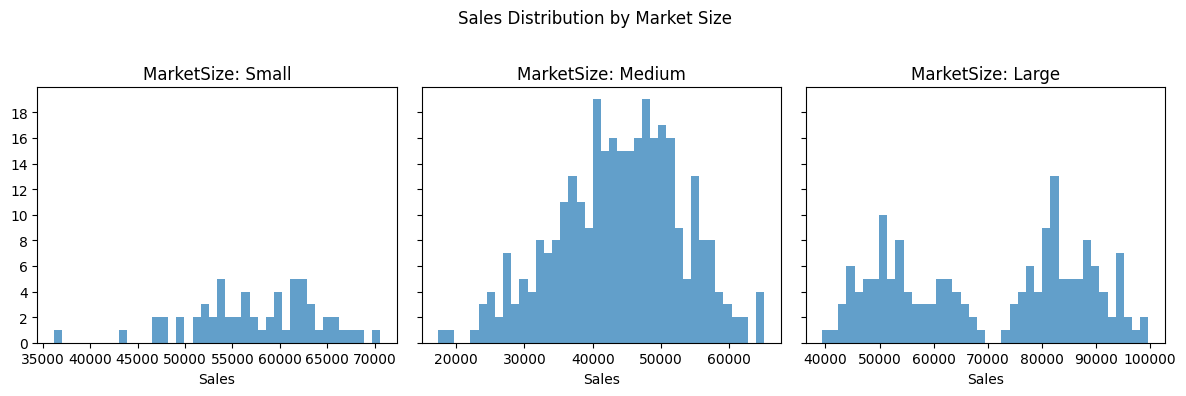

In [20]:
categories = df["MarketSize"].sort_values().unique()

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
fig.suptitle("Sales Distribution by Market Size")

for ax, category in zip(axes, categories):
    subset = df[df["MarketSize"] == category]
    ax.hist(subset["Sales"], bins=40, alpha=0.7)
    ax.set_title(f"MarketSize: {category}")
    ax.set_xlabel("Sales")
    ax.set_yticks(range(0, 19, 2))
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

The plots above suggest that particularly in the **Large Market** we see a bi-modal distribution. This can indicate that we see either a strong movement of the sales in time (weeks), e.g. through one or more promotion campaigns, or another factor divides the locations in this particular market into two groups. Further analysis, e.g. the A/B testing can give us more clarification on that.

As a consequence of this brief analysis, we did not detect any statistical outliers that have to be excluded from the dataset.

## 4. <a id='toc4_'></a>[A/B testing](#toc0_)

### 4.1. <a id='toc4_1_'></a>[Mission/Goal definition](#toc0_)

Based on the dataset description, the fast-food chain plans to add a new item to its menu but is undecided between three possible marketing campaigns for promoting the new product. Therefore the new item is introduced at random locations and different promotion is used at each location. Moreover the weekly sales of the new item are recorded for the first four weeks. Therefore the mission/goal of the A/B test is ***to determine which promotion has the greatest effect on sales***.

### 4.2. <a id='toc4_2_'></a>[Metrics definition](#toc0_)

The test can be understood as an A/B/C test, as it aims to compare the resulting average cumulative sales across three different promotions. A typical effect of marketing promotions cannot be measured here, as there is no control group (e.g., locations where the new item is introduced but not promoted). Instead, we utilize the sales figures themselves as a measure of success.

**Cumulative sales**, which sum the weekly sales over a 4-week period, provide a comprehensive measure of each promotion's overall effectiveness. This metric reflects the total impact over time, capturing both initial spikes and slower growth phases. Consequently, it serves as a reliable indicator of each promotion’s long-term success in driving sales, aligning with the primary goal of this test.

To analyze the **average cumulative sales**, we account for differences across locations within the same group of promotions, which may stem from market size or other unknown factors (see also 4.3.2). The metric selected for calculating the average is the *median*, due to the underlying non-standard distribution of the data.

To assess not only the existence of differences between average cumulative sales but also the specific effects on sales (estimated treatment effect) for each promotion, we focus on the **differences** across the promotions.

Therefore, the target metric for this analysis is the ***difference in average cumulative sales across promotions***.



### 4.3. <a id='toc4_3_'></a>[Calculations](#toc0_)

#### 4.3.1. <a id='toc4_3_1_'></a>[Cumulative Sales per Store](#toc0_)

Firstly we need to calculate the Cumulative Sales per Store:

In [ ]:
df_cum_sales = (
    df.groupby("LocationID")
    .agg({"Sales": "sum", "MarketSize": "first", "Promotion": "first"})
    .reset_index()
)
df_cum_sales.rename(columns={"Sales": "Cumulative_Sales"}, inplace=True)

Then we want to plot the distribution of the cumulative sales across the three promotions:

In [ ]:
categories = df_cum_sales["Promotion"].sort_values().unique()

fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharey=True, sharex=True)
fig.suptitle("Cumulative Sales Distribution by Promotion")

for ax, category in zip(axes, categories):
    subset = df_cum_sales[df_cum_sales["Promotion"] == category]
    ax.hist(subset["Cumulative_Sales"], bins=60, alpha=0.7)
    ax.set_title(f"Promotion: {category}")
    ax.set_xlabel("Cumulative_Sales")
    ax.set_yticks(range(0, 7, 1))
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

We can see that each of the plots have a second cluster of locations on the right side, indicating multiple locations for each promotion that have higher cumulative sales than the majority of locations. This could be influenced by the market size which we want to have a brief look at in the next subchapter.

The Q-Q Plots below highlight once more these described second clusters on the upper tail. All three distributions do not follow a normal distribution as would datapoints closer to the red line had suggested:

In [ ]:
promotions = df_cum_sales["Promotion"].unique()
fig, axes = plt.subplots(1, len(promotions), figsize=(8, 3), sharey=True)
fig.suptitle("Q-Q Plots of Cumulative Sales for Each Promotion")

for i, promotion in enumerate(promotions):
    ax = axes[i]
    subset = df_cum_sales[df_cum_sales["Promotion"] == promotion]["Cumulative_Sales"]
    stats.probplot(subset, dist="norm", plot=ax)
    ax.set_title(f"Promotion: {promotion}")
    ax.get_lines()[1].set_color("red")
    ax.set_xlabel("Theoretical Quantiles")
    ax.set_ylabel("Sample Quantiles")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### 4.3.2. <a id='toc4_3_2_'></a>[Additional thoughts on Market Size](#toc0_)

We want to see in a boxplot graph how for each promotion the cumulative sales is distributed across the three market sizes:

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(
    data=df_cum_sales,
    x="Promotion",
    y="Cumulative_Sales",
    hue="MarketSize",
    palette="Set2",
)

plt.title("Cumulative Sales Distribution by Promotion and Market Size")
plt.xlabel("Promotion")
plt.ylabel("Cumulative Sales")

plt.legend(title="Market Size")
plt.tight_layout()
plt.show()

We see that for each promotion the locations from large markets tend to have higher cumulative sales. Since market size appears to influence the promotion impact, comparing promotions within each market size would give a clearer picture of which promotion works best for a given context. This way, you can see if one promotion consistently performs well across market sizes or if certain promotions are more effective for specific market sizes. It could also help in identifying any size-specific trends that may inform future targeting strategies.

However, the small sample size sets us limitations:

In [ ]:
pd.crosstab(df_cum_sales["MarketSize"], df_cum_sales["Promotion"])

As we can see in the two-way table above the observed locations are scarce for the Small Market locations and also not very numerous for the Large  Market locations. This can produce problems when calculating a test statistic comparing the three promotions for each market.

Bootstrapping could assist us further here. But we want to keep it simple this time and neglect a deeper analysis on Market Size for now.

#### 4.3.3. <a id='toc4_3_3_'></a>[Sanity Check](#toc0_)

In [ ]:
observed_counts = df_cum_sales["Promotion"].value_counts()
observed_counts

 - Sample size: The sample size of the experiment is the sum of three variants, thus the 137 observations (locations/stores)
 - Variant proportions: The variants of the three treatment groups (Promotion 1,2,3) are rather equal, however we want to do a sanity check on the population sizing metric

The Chi-square test is widely used for testing the sample sizes on Sample Ratio Mismatch (SRM), because it works well for categorical data with expected counts across multiple groups and is straightforward when comparing observed vs. expected distributions:


In [ ]:
total_players = sum(observed_counts)
expected_counts = [total_players / 3, total_players / 3, total_players / 3]

chi2_stat, p_value = stats.chisquare(observed_counts, expected_counts)

print(f"Chi-square statistic: {chi2_stat:.04f}")
print(f"P-value: {p_value:.04f}")

The high p-value of 0.8898 shows that we cannot reject the null-hypothesis that there is a significant difference in the sample sizes across the three promotion groups. Therefore we can proceed with our analysis.

#### 4.3.4. <a id='toc4_3_4_'></a>[Average cumulative Sales and Hypothesis test](#toc0_)

In [ ]:
df_cum_sales.groupby("Promotion")["Cumulative_Sales"].describe()

We can see from the descriptive statistics above multiple information:
 - Promotion 2 has the lowest min, max, mean and median values and is therefore the least successful promotion
 - Promotion 1 has the highest min, max, mean and median values and is therefore the most successful promotion

The following boxplot summarizes once more the distribution of cumulative Sales per Promotion:

In [ ]:
plt.figure(figsize=(5, 3))
sns.boxplot(data=df_cum_sales, x="Promotion", y="Cumulative_Sales", palette="Set2")

plt.title("Cumulative Sales Distribution by Promotion")
plt.xlabel("Promotion")
plt.ylabel("Cumulative Sales")
plt.tight_layout()
plt.show()

As seen in 4.3.1. (Histograms and Q-Q plots) the cumulative sales is not normally distributed for the three promotions. Therefore we should avoid using the *mean* for the calculation of the average cumulative sales and use instead the **median**: 


In [ ]:
median_sales = df_cum_sales.groupby("Promotion")["Cumulative_Sales"].median()
median_sales

The average cumulative sales across the 4 weeks of promotion for a single location is the lowest for Promotion 2, with 186.620. Promotion 1 has the highest average cumulative sales per location with 224.300. This is roughly 20% more than Promotion 2. Promotion 3 lies with 199.410 somewhat in between both.


We want to compare all three average cumulative sales metrics and test if these stated median differences (estimated treatment effect) differ also statistically significantly from each other. The *one-way ANOVA (Analysis of Variance)*, which is designed to compare the means across three or more groups, cannot be used, since normal distribution is a prerequirement for this test. Instead, we can use the non-parametric alternative to the ANOVA, the **Kruskal-Wallis H test**. This test is suitable when comparing the medians of three or more independent groups without assuming normality:

In [ ]:
groups = [
    df_cum_sales[df_cum_sales["Promotion"] == promo]["Cumulative_Sales"]
    for promo in promotions
]
stat, p_value = stats.kruskal(*groups)
print(f"Kruskal-Wallis H Test: H-statistic = {stat:.04f}, p-value = {p_value:.04f}")

The resulting low ***p-value*** of 0.0002 suggests significant differences between the promotions.

We follow up with post hoc tests to show if the comparison holds between each of the three promotions. We use the Conover's Test which is non-parametric and adjusts for multiple comparisons. This approach allows us to make pairwise comparisons while accounting for the fact that our data does not conform to the assumptions required for parametric tests. The p-values are adjusted for multiple comparisons using the Bonferroni method. The results of Conover's test provide insights into the effectiveness of different promotions:


In [ ]:
conover_results = sp.posthoc_conover(
    df_cum_sales,
    val_col="Cumulative_Sales",
    group_col="Promotion",
    p_adjust="bonferroni",
)
print(conover_results)

We see that the ***adjusted p-values*** are low (<0.05) when comparing promotion 2 with the promotions 1 (0.0001) and 3 (0.0077). On the other hand, promotions 1 and 3 (0.6114) do not differ significantly in terms of average cumulative sales.

#### 4.3.5. <a id='toc4_3_5_'></a>[Effect size: Differences in average cumulative Sales](#toc0_)

Below we can show the estimated treatment effect or ***effect size*** in form of the **median difference** between the three promotions:

In [ ]:
promotions = median_sales.index.tolist()
for i in range(len(promotions)):
    for j in range(i + 1, len(promotions)):
        promo_a = promotions[i]
        promo_b = promotions[j]
        difference = median_sales[promo_a] - median_sales[promo_b]
        print(f"{promo_a} vs {promo_b}: {difference:.0f}")

Therefore, Promotion 1 is by 37.680 (average cumulative sales) more effective than Promotion 2, and by 24.890 (average cumulative sales) more effective than Promotion 3.
Promotion 3 is by 12.790 more effective than Promotion 2. We've seen in 4.3.3. that the difference between Promotion 1 and 3 is not significant, while the other two differences withstand the signficance test.

When dealing with non-parametric data, calculating **confidence intervals** for medians or median differences can be a bit tricky since typical methods assume normality. *Analytical Methods* are limited and often rely on large sample sizes for normal approximation. A common approach to calculate a confidence interval is to use bootstrapping, which involves resampling your data with replacement and computing the median differences from these resamples. **Bootstrapping** allows for the empirical assessment of the distribution of differences without making strong parametric assumptions.



In [ ]:
sys.path.append(os.path.abspath(".."))
from custom_modules.bootstrapping import bootstrap_median_difference

median_diffs = []
ci_bounds = []
promo_pairs = []
for i in range(len(promotions)):
    for j in range(i + 1, len(promotions)):
        promo_a = promotions[i]
        promo_b = promotions[j]
        data_a = df_cum_sales[df_cum_sales["Promotion"] == promo_a]["Cumulative_Sales"]
        data_b = df_cum_sales[df_cum_sales["Promotion"] == promo_b]["Cumulative_Sales"]
        median_diff = np.median(data_a) - np.median(data_b)
        ci_diff = bootstrap_median_difference(data_a, data_b)
        start, end = ci_diff
        median_diffs.append(median_diff)
        ci_bounds.append(ci_diff)
        promo_pairs.append((promo_a, promo_b, ci_diff, median_diff))

for promo_a, promo_b, ci_diff, median_diff in promo_pairs:
    start, end = ci_diff
    print(
        f"{promo_a} vs {promo_b}: median={median_diff:.0f} with bootstrapped CI between {start:.0f} and {end:.0f}"
    )

From the bootstrapped confidence intervalls above we can see why the difference between Promotion 1 vs. 3 is not significant: It covers also the value of zero. 

The calculated median differences from above fit very well into these confidence intervalls.




### 4.4. <a id='toc4_4_'></a>[Results and Decisions](#toc0_)

The question *which promotion has the greatest effect on sales* can be answered looking at the visualization of the key metric of the *differences in average cumulative sales* between the three promotions:

In [ ]:
labels = [
    f"{promotions[i]} vs {promotions[j]}"
    for i in range(len(promotions))
    for j in range(i + 1, len(promotions))
]
median_diffs = np.array(median_diffs)
lower_bounds = np.array([ci[0] for ci in ci_bounds])
upper_bounds = np.array([ci[1] for ci in ci_bounds])

plt.figure(figsize=(6, 4))
bars = plt.bar(
    labels,
    median_diffs,
    yerr=[median_diffs - lower_bounds, upper_bounds - median_diffs],
    capsize=5,
    color=["royalblue", "lightsteelblue", "cornflowerblue"],
)

plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
plt.xlabel("Promotion pairs")
plt.ylabel("Median Difference of Cumulative Sales")
plt.title("Median Differences Between Promotions with Bootstrapped CIs", pad=15)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.yticks([])
for bar, median, ci in zip(bars, median_diffs, ci_bounds):
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 1.8,
        yval,
        f"{median:,.0f}",
        ha="left",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )
    plt.text(
        bar.get_x() + bar.get_width() / 2.3,
        yval,
        f"({ci[0]:,.0f},\n {ci[1]:,.0f})",
        ha="right",
        va="top",
        fontsize=9,
    )

plt.tight_layout()
plt.show()

Pomotion 1 promised with the highest average cumulative sales that it is the most effective promotion. The differences between the median average cumulative sales of all three promotions are plotted above. It shows that Promotion 1 has an average cumulative sales that is 37.680 higher than Promotion 2, which is also statistically significant. There is also a higher average cumulative sales than Promotion 3, but it is not statistically signficant. The bootstrapped Confidence Intervalls confirm the significant differences.

As a result we can say that Promotions 1 is the most effective promotion but it is not statistically significantly more effective than Promotion 3.

Therefore Promotion 1 is the prefered method to promot the newly introduced item. Promotion 3 is the second best promotion, signficiantly more effective than Promotion 2. The latter must be avoided.

As shown in 4.3.2. there are clear differences between the effectiveness of the Promotions across the three Market Sizes. However, the brief look into the distribution of average cumulative sales suggest that Promotion 1 is still the most prefered promotion. Further analysis could be done to confirm this assumption. The bootstrapping method could be used to deal with small sample sizes when evaluating the Promotions across the three Market Sizes. 

## 5. <a id='toc5_'></a>[Dashboard](#toc0_)

The dashboard on **Sales Metrics for New Item Promotions** is available [here](https://lookerstudio.google.com/reporting/2963e7f0-3892-40cc-a343-32ebf5ee1bdd). Since the A/B test metric used in this analysis is the ***difference in average cumulative sales across promotions*** but the dashboard must show metric movement over time (based on weeks), another metric was chosen. 

The dashboard shows the impact of the three promotions as the **average (median) sales per store** across the four weeks in a *line chart*. While particular promotions or weeks can be selected, the graph can also be filtered additionally by the market size where locations are situated in. Moreover, two *scorecards* show the **cumulative total sales**and the **average (median) sales per store** of the current selection.